# Simple state space model for 2pp voting intention (using pymc3)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span><ul class="toc-item"><li><span><a href="#Set-up-Analysis-constants" data-toc-modified-id="Set-up-Analysis-constants-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Set up Analysis constants</a></span></li></ul></li><li><span><a href="#Load-2pp-data-and-prepare-for-analysis" data-toc-modified-id="Load-2pp-data-and-prepare-for-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load 2pp data and prepare for analysis</a></span></li><li><span><a href="#The-model" data-toc-modified-id="The-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>The model</a></span><ul class="toc-item"><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#Define-a-probabilistic-model" data-toc-modified-id="Define-a-probabilistic-model-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Define a probabilistic model</a></span></li><li><span><a href="#Sampling-/-fit-data-to-model" data-toc-modified-id="Sampling-/-fit-data-to-model-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Sampling / fit data to model</a></span></li><li><span><a href="#Check-diagnostics" data-toc-modified-id="Check-diagnostics-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Check diagnostics</a></span></li><li><span><a href="#Make-a-quick-plot-from-the-diagnostics" data-toc-modified-id="Make-a-quick-plot-from-the-diagnostics-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Make a quick plot from the diagnostics</a></span></li></ul></li><li><span><a href="#Model-outputs" data-toc-modified-id="Model-outputs-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model outputs</a></span></li></ul></div>

## Python setup

In [1]:
# data science imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# pymc probabilistic programming
import arviz as az
import pymc3 as pm

# local imports
import common
from common import COLOR_COALITION, P_COLOR_COALITION

In [2]:
# report versions
print(f'numpy: {np.__version__}')
print(f'pandas: {pd.__version__}')
print(f'matplotlib: {mpl.__version__}')
print(f'pymc3: {pm.__version__}')
print(f'arviz: {az.__version__}')

numpy: 1.21.5
pandas: 1.3.5
matplotlib: 3.5.1
pymc3: 3.11.4
arviz: 0.11.4


In [3]:
# pymc3 set-up
az.style.use("arviz-darkgrid")


In [4]:
# path to the model data - assume it exists
DATA_DIR = '../data/'

In [5]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')

### Set up Analysis constants

In [6]:
# Analysis based on this data ...
data_file = f'{DATA_DIR}primary_vote.csv' # f'{DATA_DIR}two_party_preferred.csv'
POLL_COLUMN = 'Calculated 2pp L/NP' #'2pp vote L/NP'

# Minimum polls requirement for a pollster
MIMIMUM_POLLS_FROM_POLLSTER = 2
# The one ANU poll since 2019 look like a rogue outlier, so let's exclude

# Plot left-side footnotes
LFOOTER = (
    'Polling data from Wikipedia; '
    '2pp calculated from primary votes and 2019 preference flows; '
    f'Pollsters ignored with < {MIMIMUM_POLLS_FROM_POLLSTER} polls.'
)

## Load 2pp data and prepare for analysis

In [7]:
# Check the data file has been updated today
common.check_file_current(data_file, 
    'Make sure you run the data capture notebook first')

In [8]:
# read in 2pp data; remind me, what are the column names ...
tpp = pd.read_csv(data_file, parse_dates=['Mean Date'], index_col=0)
tpp['Mean Date'] = pd.to_datetime(tpp['Mean Date'])
tpp = tpp.sort_values('Mean Date')
tpp.columns

Index(['Primary vote L/NP', 'Primary vote ALP', 'Primary vote GRN',
       'Primary vote ONP', 'Primary vote OTH', 'Date', 'Mean Date', 'Brand',
       'Interview mode', 'Sample size', 'Calculated 2pp L/NP',
       'Calculated 2pp ALP'],
      dtype='object')

In [9]:
# Number of polls
len(tpp)

109

In [10]:
# Number of polls from each pollster
brand_counts = tpp['Brand'].value_counts()
brand_counts

Newspoll-YouGov                   40
Essential                         40
Roy Morgan                        20
Resolve Strategic                  8
Australian National University     1
Name: Brand, dtype: int64

In [11]:
# Remove pollsters with minimal polling history
keep = brand_counts[brand_counts >= MIMIMUM_POLLS_FROM_POLLSTER].index
tpp = tpp[tpp['Brand'].isin(keep)]
tpp['Brand'].value_counts()

Newspoll-YouGov      40
Essential            40
Roy Morgan           20
Resolve Strategic     8
Name: Brand, dtype: int64

In [12]:
len(tpp)

108

## The model

### Data preparation

In [13]:
y_obs = tpp[POLL_COLUMN]
y_obs.tail()

104    47.159000
105    50.930303
106    46.941489
107    46.249000
108    46.707000
Name: Calculated 2pp L/NP, dtype: float64

In [14]:
centre_offset = 0 - y_obs.mean()
centre_offset

-49.51013471596513

In [15]:
c_y_obs = y_obs + centre_offset

In [16]:
n_polls = len(y_obs)
n_polls

108

In [17]:
day_zero = tpp['Mean Date'].min()
n_days = int((tpp['Mean Date'].max() - day_zero) / pd.Timedelta(days=1)) + 1
n_days

861

In [18]:
n_brands = len(tpp.Brand.unique())
n_brands

4

In [19]:
poll_brand = tpp.Brand.astype('category').cat.codes
poll_brand.tail()

104    3
105    2
106    0
107    3
108    1
dtype: int8

In [20]:
brand_map = {b: c for b, c in zip(tpp.Brand, poll_brand)}
brand_map

{'Newspoll-YouGov': 1, 'Roy Morgan': 3, 'Essential': 0, 'Resolve Strategic': 2}

In [21]:
poll_day = ((tpp['Mean Date'] - tpp['Mean Date'].min()) / pd.Timedelta(days=1)).astype(int)

In [22]:
assumed_sample_size = 1000
pseudoSampleSigma = np.sqrt((50 * 50) / assumed_sample_size)
pseudoSampleSigma

1.5811388300841898

### Define a probabilistic model

In [23]:
innovation = 0.15
with pm.Model() as model:
    # priors 
    p_house_bias = pm.Cauchy("p_house_bias", alpha=0, beta=4, shape=n_brands)
    # next line is the sum-to-zero constraint on the house bias prior
    house_bias = pm.Deterministic('house_bias', var=(p_house_bias - p_house_bias.mean()))
    #innovation = pm.HalfNormal('innovation', 0.5)

    # temporal model
    grw = pm.GaussianRandomWalk('grw', mu=0, sd=innovation, shape=n_days)
    
    # polling bias model 
    house_effects = pm.Deterministic('house_effects', var=house_bias[poll_brand.to_list()])
    
    # Likelihood - the observational model
    predicted = pm.Deterministic('predicted', var=grw[poll_day] + house_effects)
    obs = pm.Normal("obs", mu=predicted, sigma=pseudoSampleSigma, observed=c_y_obs)

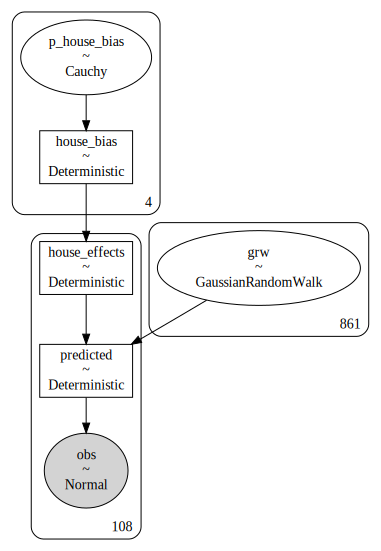

In [24]:
# I really like this feature ...
pm.model_to_graphviz(model)

### Sampling / fit data to model

In [25]:
with model:    
    trace = pm.sample(1000, tune=1000, progressbar=True, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [grw, p_house_bias]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 98 seconds.


### Check diagnostics

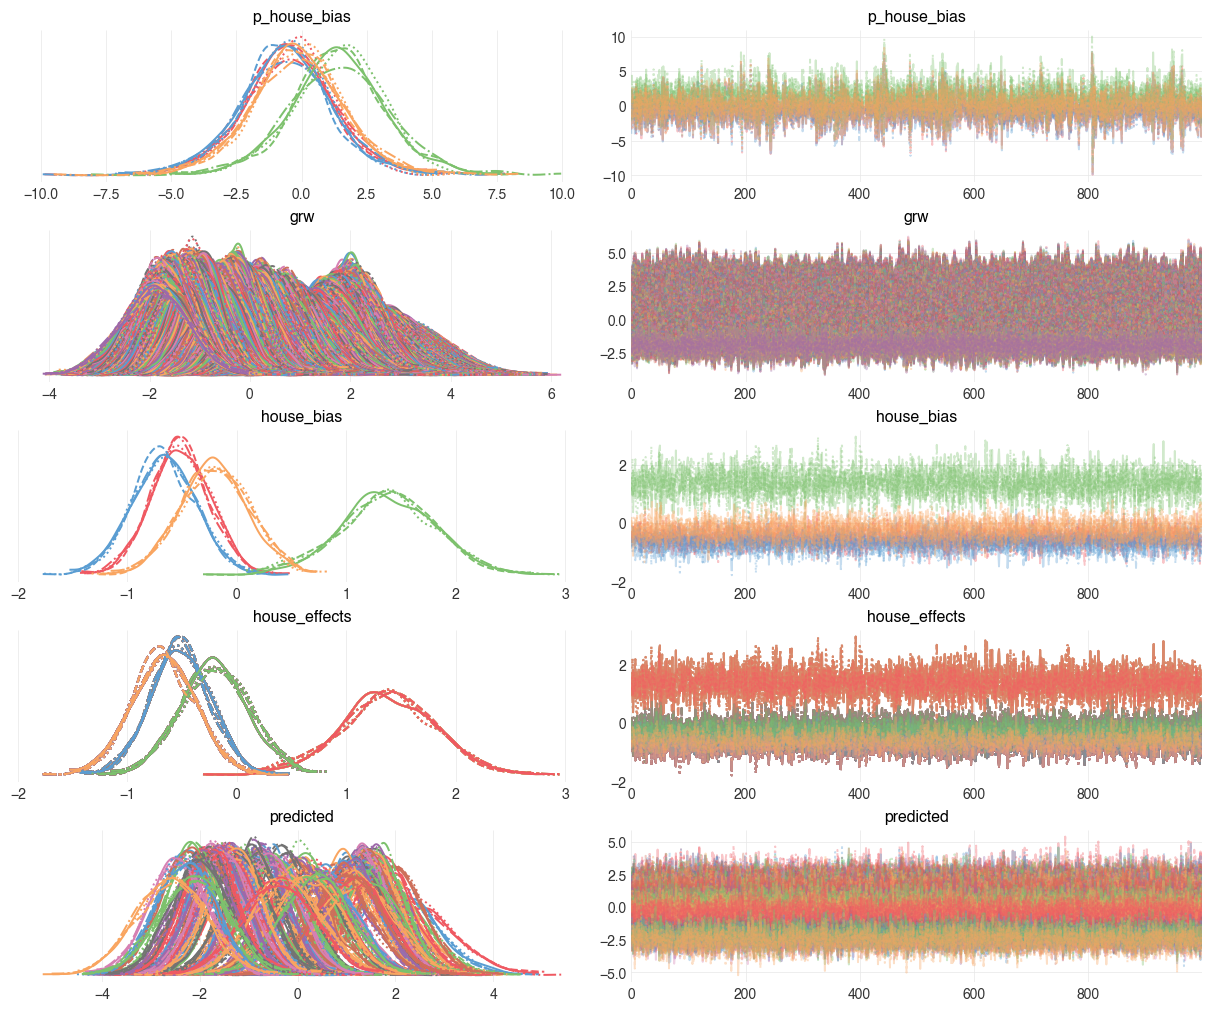

In [26]:
with model:
    summary = az.summary(trace) # used below
    az.plot_trace(trace)

In [27]:
# Estimated Bayesian Fraction of Missing Information ...
# Good if close to one; bad if close to zero ...
bfmi = az.bfmi(trace)
if (bfmi <= 0.4).any():
    print(f'Note: the BFMI could be problematic ({bfmi})')

In [28]:
# R-hat chain convergence diagnostic
# ESS - effective sample size (used to be n_eff)
RHAT_THRESHOLD = 1.05
ESS_THRESHOLD = 1000
rhat = az.rhat(trace)
ess = az.ess(trace)
for var in ['house_bias', 'grw']:
    if (rhat[var] > RHAT_THRESHOLD).any():
        print(f'Check {var} - chain convergence')
    if (ess[var] < ESS_THRESHOLD).any():
        print(f'Check {var} - effective sample size')

### Make a quick plot from the diagnostics

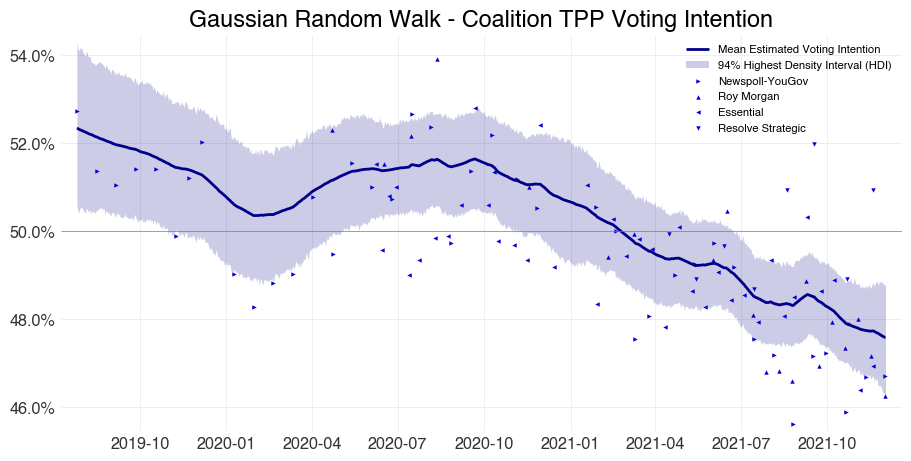

In [29]:
# key model data
walk = summary[summary.index.str.contains('grw')]['mean'] - centre_offset
walk.index = pd.date_range(start=day_zero, periods=n_days)
low = summary[summary.index.str.contains('grw')]['hdi_3%'] - centre_offset
low.index = walk.index
high = summary[summary.index.str.contains('grw')]['hdi_97%'] - centre_offset
high.index = walk.index

# plot
fig, ax = plt.subplots()
ax.margins(0.02)
ax.plot(walk, lw=2.0, c=COLOR_COALITION, label='Mean Estimated Voting Intention')
ax.fill_between(x=low.index, y1=low, y2=high,
                color=COLOR_COALITION, alpha = 0.2,
                label='94% Highest Density Interval (HDI)')

markers = ['<', '>', 'v', '^', '*']
for brand, code in brand_map.items():
    selected = tpp[tpp.Brand == brand]
    ax.scatter(selected['Mean Date'], selected[POLL_COLUMN], 
           c=P_COLOR_COALITION, s=10, marker=markers[code], 
               label=brand)

ax.axhline(50, lw=0.5, c='gray')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
title = 'Gaussian Random Walk - Coalition TPP Voting Intention'
ax.set_title(title)
ax.legend(loc='best')
fig.savefig('../charts/'+title.replace(' ', '-')+'-pymc3.png', dpi=300)
plt.show()
plt.close()